<a href="https://colab.research.google.com/github/bishair/Pirna/blob/main/G1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import display
import joblib


In [11]:
uploaded_file = files.upload()

Saving G1river.xlsx to G1river.xlsx


In [19]:
# Read the groundwater level data
gw_data = pd.read_excel('G1-edited.xlsx')
gw_data.dropna(inplace=True)
gw_data['Date'] = pd.to_datetime(gw_data['Date'], format='%d/%m/%Y %H:%M')
print(gw_data)

                     Date       G1
0     2019-04-09 03:30:00  110.389
1     2019-04-09 04:30:00  110.386
2     2019-04-09 05:30:00  110.384
3     2019-04-09 06:30:00  110.381
4     2019-04-09 07:30:00  110.378
...                   ...      ...
38617 2023-09-04 08:00:00  109.378
38618 2023-09-04 09:00:00  109.378
38619 2023-09-04 10:00:00  109.376
38620 2023-09-04 11:00:00  109.377
38621 2023-09-04 12:00:00  109.375

[38609 rows x 2 columns]


In [21]:
from dateutil import parser
import pandas as pd

def parse_dates(date):
    if isinstance(date, pd.Timestamp):
        return date  # Return the date as is if it's already a datetime object
    try:
        return parser.parse(date)
    except ValueError:
        #print(f"Unable to parse date: {date}")
        return None
    except TypeError:
        #print(f"Invalid type for date: {date}")
        return None

# Read the data
river_data = pd.read_excel('G1river.xlsx')
# Apply the function to the Date column
river_data['Date'] = river_data['Date'].apply(parse_dates)
#print(river_data)


In [22]:
river_data['Date'] = pd.to_datetime(river_data['Date'], format='%Y/%m/%d %H:%M')
river_data.dropna(inplace=True)
print(river_data)

                     Date  River
285   2019-01-13 00:00:00  222.0
286   2019-01-13 01:00:00  223.0
287   2019-01-13 02:00:00  223.0
288   2019-01-13 03:00:00  225.0
289   2019-01-13 04:00:00  225.0
...                   ...    ...
41837 2023-11-29 15:00:00  238.0
41838 2023-11-29 16:00:00  238.0
41839 2023-11-29 17:00:00  237.0
41840 2023-11-29 18:00:00  237.0
41841 2023-11-29 19:00:00  236.0

[25301 rows x 2 columns]


In [24]:
merged_data = pd.merge_asof(gw_data.sort_values('Date'), river_data.sort_values('Date'), on='Date', direction='nearest')

In [25]:
# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)
print(merged_data)

                          G1  River
Date                               
2019-04-09 03:30:00  110.389  210.0
2019-04-09 04:30:00  110.386  210.0
2019-04-09 05:30:00  110.384  210.0
2019-04-09 06:30:00  110.381  210.0
2019-04-09 07:30:00  110.378  210.0
...                      ...    ...
2023-09-04 08:00:00  109.378  151.0
2023-09-04 09:00:00  109.378  151.0
2023-09-04 10:00:00  109.376  151.0
2023-09-04 11:00:00  109.377  151.0
2023-09-04 12:00:00  109.375  151.0

[38609 rows x 2 columns]


In [28]:
n_steps = 24

# Split the original data first before scaling
train_size = int(len(merged_data) * 0.7)
resampled_data_train = merged_data[:train_size]
resampled_data_test = merged_data[train_size:]

# Apply MinMaxScaler only to the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(resampled_data_train)
test_scaled = scaler.transform(resampled_data_test)

joblib.dump(scaler, 'scaler.gz')


# Function to create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences for training and testing sets
X_train, y_train = create_sequences(train_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

# Print shapes of X_train, y_train, X_test, y_test for verification
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (27002, 24, 2)
y_train shape: (27002,)
X_test shape: (11559, 24, 2)
y_test shape: (11559,)


In [29]:
input_shape=(X_train.shape[1], X_train.shape[2])

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l1_l2

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=input_shape,   #input shape => (timesteps, features).  X => (samples, timesteps, features)
         dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.2),
    LSTM(units=50, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
422/422 [==============================] - 41s 73ms/step - loss: 0.0621
Epoch 2/50
422/422 [==============================] - 31s 74ms/step - loss: 0.0048
Epoch 3/50
422/422 [==============================] - 32s 75ms/step - loss: 0.0040
Epoch 4/50
422/422 [==============================] - 31s 74ms/step - loss: 0.0037
Epoch 5/50
422/422 [==============================] - 30s 72ms/step - loss: 0.0035
Epoch 6/50
422/422 [==============================] - 32s 75ms/step - loss: 0.0034
Epoch 7/50
422/422 [==============================] - 32s 76ms/step - loss: 0.0031
Epoch 8/50
422/422 [==============================] - 30s 72ms/step - loss: 0.0031
Epoch 9/50
422/422 [==============================] - 30s 71ms/step - loss: 0.0030
Epoch 10/50
422/422 [==============================] - 32s 75ms/step - loss: 0.0029
Epoch 11/50
422/422 [==============================] - 30s 72ms/step - loss: 0.0030
Epoch 12/50
422/422 [==============================] - 30s 71ms/step - loss: 0.0028
E

In [30]:
model.save('lstmmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
model = load_model('lstmmodel.h5')
scaler = joblib.load('scaler.gz')

In [32]:
# Function to retrain the model with new data
def retrain_model(model, X_new, y_new, epochs=5, batch_size=32):
    # Partial retraining of the model with new data
    model.fit(X_new, y_new, epochs=epochs, batch_size=batch_size, shuffle=True)
    return model


1/1 [==============================] - 0s 30ms/step


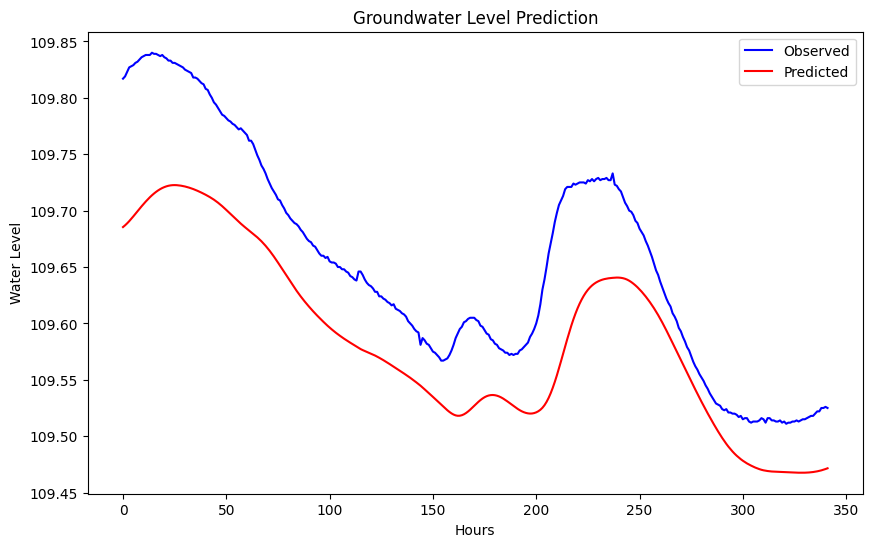

KeyboardInterrupt: 

In [34]:

import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import display, clear_output


window_size = 24

actual_values = []
predicted_values = []
errors = []


fig, ax = plt.subplots(figsize=(10, 6))

for i in range(X_test.shape[0]):
    X_input = X_test[i, :, :]            #selecting a single sequence from X_test, X_input  have the shape [timesteps, features] => (24, 2)
    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))  #LSTM models  expect input in the form of 3D array [batch_size, timesteps, features] => (1, 24, 2)

    # Make a prediction
    forecast = model.predict(X_input)    #shapeof forecast => (1 timesequence of 24 steps,1 feature) => e.g [[0.28847086]]
    dummy = np.zeros((1, 2))
    dummy[:, 0] = forecast[:, 0]
    forecasted_value = scaler.inverse_transform(dummy)[0, 0]
    predicted_values.append(forecasted_value)    #Forecasted value inverse transformed => e.g 109.58

    actual = y_test[i] if i < len(y_test) else None   #fetching the observed value corresponding to the i-th sequence in X_test
    if actual is not None:
        actual_transformed = scaler.inverse_transform([[actual, 0]])[0, 0]
        actual_values.append(actual_transformed)     #Observed value => e.g 109.639

    error = abs(forecasted_value - actual_transformed)
    errors.append(error)


    ax.clear()
    ax.plot(actual_values, label='Observed', color='blue')
    ax.plot(predicted_values, label='Predicted', color='red')
    ax.set_title('Groundwater Level Prediction')
    ax.set_xlabel('Hours')
    ax.set_ylabel('Water Level')
    ax.legend()

    if len(errors) >= window_size:
        windowed_errors = errors[-window_size:]
        mean_error = np.mean(windowed_errors)
        std_error = np.std(windowed_errors)
        threshold = mean_error + 3 * std_error  #error  greater than 3 standard deviations from the mean error

        windowed_anomalies = [j for j, e in enumerate(windowed_errors) if e > threshold]
        #if windowed_anomalies:
          #print(f"Anomalies detected at indices: {[j + i - window_size + 1 for j in windowed_anomalies]}")
          #Retrain the model with the most recent window of data
          #model = retrain_model(model, X_test[i-window_size+1:i+1], y_test[i-window_size+1:i+1])



    display(fig)
    plt.pause(0.5)

    clear_output(wait=True)


plt.close(fig)

